# Assignment 4: Correlation Analysis and Bootstrapping

## Objective

The field of statistics is divided into two major parts: descriptive and inferential. In this assignment, we will cover two important topics in statistics: correlation analysis and bootstrapping, where the former belongs to the descriptive part and the latter belongs to the inferential part. After this assignment, you will be able to answer the following questions:

1. How to visualize the relationship between two variables?  
2. What is Pearson's correlation? How to compute it?
3. What is Spearman's rank correlation? How to compute it?
4. What's the difference between Pearson's correlation and Spearman's rank correlation? 
5. How to estimate a population parameter based on a sample?
6. How to use the bootstrap to quantify the uncertainty of an estimated value?

**Requirements:**
* Use [pandas](https://pandas.pydata.org/) to manipulate data.
* Use [matplotlib](https://matplotlib.org/) or [seaborn](https://seaborn.pydata.org) to make plots.
* Please pay attention to visualization principles. 


The data can be downloaded from [A4-data.zip](A4-data.zip).


## Part 1. Correlation Analysis

As a data scientist, you often face this kind of question: "Are A and B correlated?" For example, 

* Do Canadian Currency and Oil Price move together?
* Do Vancouver Housing Price and US Stock Market have any correlation?
* Are GPA and Gender independent? 

To answer these questions, you need to conduct a correlation analysis. 

Imagine you are a data scientist working at a real-estate company. You download a property_tax_report from this [webpage](https://opendata.vancouver.ca/explore/dataset/property-tax-report/table/?refine.report_year=2021). The dataset contains information on properties from BC Assessment (BCA) and City sources in 2021.  

You may think that for a newly built house, it tends to have a higher price than the ones built decades ago. In this assignment, your first job is to figure out whether YEAR_BUILT and HOUSE_PRICE are correlated. 

We first load the data as a DataFrame. 

In [1]:
import pandas as pd

df = pd.read_csv("property-tax-report_2021.csv")

df['HOUSE_PRICE'] = df.apply(lambda x: (x['CURRENT_LAND_VALUE'] \
                                        +x['CURRENT_IMPROVEMENT_VALUE'])/1000000.0, axis = 1)

### Task A. Visualizations

Since the housing price varies a lot by locations, we will only consider the houses whose postcode starts with 'V6A'. Furthermore, we remove the houses that were built before 1900.

<img src="img/v6a.png" width="400">

In the following, please make two subplots in one row. For the left subplot, it is a scatter plot with X = `YEAR_BUILT` and Y = `HOUSE_PRICE`; for the right subplot, it is a hexbin plot (gridsize = 20) with X = `YEAR_BUILT` and Y = `HOUSE_PRICE`.

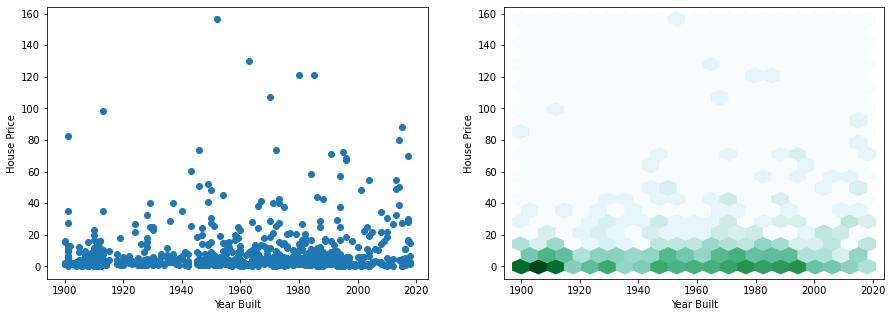

In [2]:
#<-- Write Your Code -->
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Filtering the dataframe
filtered_df = df[(df['PROPERTY_POSTAL_CODE'].str.startswith('V6A', na=False)) & \
                 (df['YEAR_BUILT']>=1900) & (df['LEGAL_TYPE']=='LAND')]

# Handle Nan values if necessary
# col_avrg = filtered_df['HOUSE_PRICE'].mean()
# filtered_df['HOUSE_PRICE'].fillna(col_avrg, inplace=True)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
ax1 = axes[0]
ax2 = axes[1]

# Plotting the data points
ax1.set(xlabel='Year Built', ylabel='House Price')
ax1.scatter(x=filtered_df["YEAR_BUILT"], y=filtered_df["HOUSE_PRICE"])

ax2.set(xlabel='Year Built', ylabel='House Price')
ax2.hexbin(x=filtered_df["YEAR_BUILT"], y=filtered_df["HOUSE_PRICE"], gridsize=20, cmap ='BuGn', bins='log')

plt.show()

Please write down the **two** most interesting findings that you draw from the plot.
**Findings**
1. The house with highest price was built in the year 1952 and the price value is 160 million.
2. After 1940, the number of houses built with house price greater than 40 million is more compared to the previous years.

The above plots provide a general impression of the relationship between variables. There are some other visualizations that can provide more insights. One option is to bin one variable and plot percentiles of the other. 


In the following, please make three subplots in a row, where each subplot is a scatter plot with X = YEAR_BUILT and Y = HOUSE_PRICE. 
* The first subplot shows how the 25th percentile of `HOUSE_PRICE` changes over years (X = `YEAR_BUILT`, Y = `25TH_HOUSE_PRICE`); 
* The second subplot shows how the 50th percentile of `HOUSE_PRICE` changes over years (X = `YEAR_BUILT`, Y = `50TH_HOUSE_PRICE`); 
* The third subplot shows how the 75th percentile of `HOUSE_PRICE` changes over years (X = `YEAR_BUILT`, Y = `75TH_HOUSE_PRICE`);  


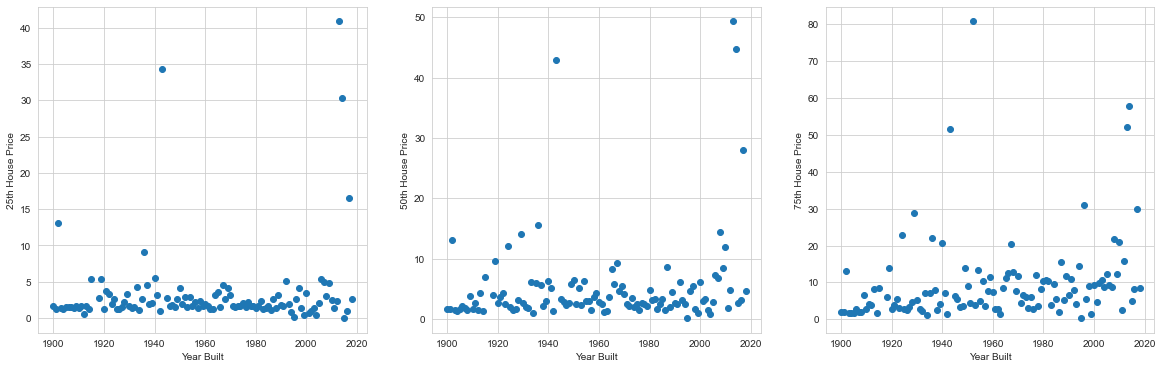

In [3]:
#<-- Write Your Code -->
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# 25th Percentile
ax1 = axes[0]
quantile_25 = filtered_df.groupby(['YEAR_BUILT'])['HOUSE_PRICE'].quantile(0.25)
ax1.set(xlabel='Year Built', ylabel='25th House Price')
ax1.scatter(x=quantile_25.index, y=quantile_25.values)

# 50th Percentile
ax2 = axes[1]
quantile_50 = filtered_df.groupby(['YEAR_BUILT'])['HOUSE_PRICE'].quantile(0.50)
ax2.set(xlabel='Year Built', ylabel='50th House Price')
ax2.scatter(x=quantile_50.index, y=quantile_50.values)

# 75th Percentile
ax3 = axes[2]
quantile_75 = filtered_df.groupby(['YEAR_BUILT'])['HOUSE_PRICE'].quantile(0.75)
ax3.set(xlabel='Year Built', ylabel='75th House Price')
ax3.scatter(x=quantile_75.index, y=quantile_75.values)

plt.show()

Please write down the **two** most interesting findings that you draw from the plot.

**Findings**
1. In 75th percentile plot, there are more number of houses with the price greater than 10 million compared to other percentiles and the highest price is above 80 million.
2. The distribution of house prices for 25th percentile is more concentrated betweeen 0 and less than 5 million whereas in other plots it is slightly spread.

### Task B. Correlation Coefficient

A correlation coefficient is a numerical measure of some type of correlation, meaning a statistical relationship between a pair of variables. 

In the following, please implement `calc_pearson()` and `calc_spearman()`, respectively. Note that you are *NOT* allowed to use [corr](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.corr.html) from Pandas or [pearsonr](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html#scipy.stats.pearsonr)/[spearmanr](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html#scipy.stats.spearmanr) from scipy.stats to do this task. In other words, you need to implement the actual algorithms for pearson and spearman.

In [4]:
import math

def calc_pearson(df, x, y):
    #<-- Write Your Code -->   
    mean_x = df[x].mean()
    mean_y = df[y].mean()
    column_x = df[x] - mean_x
    column_y = df[y] - mean_y
    column_x2 = column_x ** 2
    column_y2 = column_y ** 2
    numerator = column_x.multiply(column_y).sum()
    denominator = math.sqrt(column_x2.sum() * column_y2.sum())
    return numerator / denominator
    
def calc_spearman(df, x, y):
    #<-- Write Your Code -->
    rank_x = df[x].rank()
    rank_y = df[y].rank()
    diff = rank_x.sub(rank_y)
    diff_2 = diff ** 2
    no_obs = len(df)
    numerator = 6 * diff_2.sum()
    denominator = no_obs * (no_obs**2 - 1)
    return (1- (numerator / denominator))

Then, you can use these two functions to compute the Pearson's correlation as well as Spearman's rank correlation for three pairs of variables: <`25TH_HOUSE_PRICE`, `YEAR_BUILT`>, <`50TH_HOUSE_PRICE`, `YEAR_BUILT`>, and <`75TH_HOUSE_PRICE`, `YEAR_BUILT`>. 

In [5]:
# Creating a dataframe using the computed percentile series
dfcor = pd.DataFrame({"25TH_HOUSE_PRICE":quantile_25, "50TH_HOUSE_PRICE":quantile_50, "75TH_HOUSE_PRICE":quantile_75}).reset_index(level=0)
print(dfcor.head(10))
print()

for TH in ["25TH", "50TH", "75TH"]:
    print(TH+"_HOUSE_PRICE\t pearson=%f\t spearman=%f"  \
          %(calc_pearson(dfcor, "YEAR_BUILT", TH+"_HOUSE_PRICE"), \
            calc_spearman(dfcor, "YEAR_BUILT", TH+"_HOUSE_PRICE")))

   YEAR_BUILT  25TH_HOUSE_PRICE  50TH_HOUSE_PRICE  75TH_HOUSE_PRICE
0      1900.0          1.653000           1.72000           2.04615
1      1901.0          1.229325           1.59650           2.01200
2      1902.0         13.056000          13.05600          13.05600
3      1903.0          1.382600           1.47570           1.61030
4      1904.0          1.204300           1.40400           1.70100
5      1905.0          1.491350           1.61250           1.81925
6      1906.0          1.552750           2.15400           2.84135
7      1907.0          1.528800           1.76955           2.03275
8      1908.0          1.407475           1.58920           1.87325
9      1909.0          1.674250           3.84195           6.61775

25TH_HOUSE_PRICE	 pearson=0.139627	 spearman=0.046738
50TH_HOUSE_PRICE	 pearson=0.196118	 spearman=0.192765
75TH_HOUSE_PRICE	 pearson=0.240414	 spearman=0.403690


Please write down the **two** most interesting findings that you draw from the result.

**Findings**
1. From the correlation values, the house prices of 25th percentile for each year have the least correlation with year built and the relationship value increases for 50th and 75th percentile. 
2. In the year 1902, the 25th, 50th and 75th percentile house price has abnormally high value compared to other values in each year.

## Part 2. Bootstrapping

In reality, it is more often than not that you can only collect a sample of the data. Whenever you derive a conclusion from a sample (e.g., Vancouver's housing price has increased by 10% since last year), you should ALWAYS ask yourself: **"CAN I TRUST IT?"**. In other words, you want to know that if the same analysis was conducted on the full data, would the same conclusion be derived? In Part 2, you will learn how to use bootstrapping to answer this question. 

In [6]:
df_sample = pd.read_csv("property-tax-report_2021_sample.csv")

df_sample['CURRENT_PRICE'] = df_sample.apply(lambda x: x['CURRENT_LAND_VALUE'] \
                                             +x['CURRENT_IMPROVEMENT_VALUE'], axis = 1)

df_sample['PREVIOUS_PRICE'] = df_sample.apply(lambda x: x['PREVIOUS_LAND_VALUE'] \
                                              +x['PREVIOUS_IMPROVEMENT_VALUE'], axis = 1)

df_sample = df_sample[df_sample['LEGAL_TYPE'] == 'STRATA']

### Task 1. Analysis Result Without Bootstrapping

Please compute the median of PREVIOUS_PRICE and CURRENT_PRICE, respectively, and compare them in a bar chart.

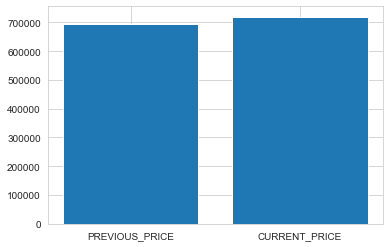

In [12]:
# --- Write your code below ---
# Storing the median values of each price
pre_price_median = df_sample['PREVIOUS_PRICE'].median()
cur_price_median = df_sample['CURRENT_PRICE'].median()
plt.bar(['PREVIOUS_PRICE','CURRENT_PRICE'], [pre_price_median, cur_price_median])
plt.show()

### Task 2. Analysis Result With Bootstrapping

From the above chart, we find that the median of PREVIOUS_PRICE is about 0.77 M, and the median of CURRENT_PRICE is about 0.72 M. Since the numbers were obtained from the sample, **"CAN WE TRUST THESE NUMBERS?"**

In the following, please implement the bootstrap by yourself, compute a 95%-confidence interval for each number, and add the confidence intervals to the above bar chart. [This document](./MIT18_05S14_Reading24.pdf) gives a good tutorial about the bootstrap. You can find the description of the algorithm in Section 7.

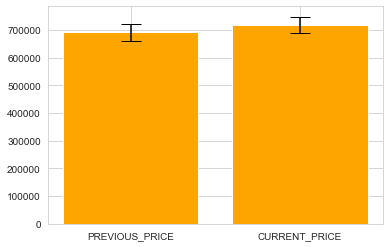

In [14]:
# --- Write your code below ---
boot_diff_cp = list()
boot_diff_pp = list()
sample_data = df_sample[['PREVIOUS_PRICE', 'CURRENT_PRICE']]

# Computing the bootstrap differences
sample_len = len(sample_data)
for i in range(0, 1000):
    random_sample = sample_data.sample(n=sample_len, replace=True)
    median_diff1 = random_sample['PREVIOUS_PRICE'].median() - pre_price_median
    median_diff2 = random_sample['CURRENT_PRICE'].median() - cur_price_median
    boot_diff_cp.append(median_diff2)
    boot_diff_pp.append(median_diff1)

# Sorting the list
boot_diff_cp.sort()
boot_diff_pp.sort()

# pick out .025 and 0.975 critical values for 95 confidence interval
ci1 = [boot_diff_pp[24], boot_diff_pp[974]]
ci2 = [boot_diff_cp[24], boot_diff_cp[974]]
ci_values = [ci1, ci2]

# Plotting the confidence intervals on the bar graph
plt.bar(['PREVIOUS_PRICE','CURRENT_PRICE'], [pre_price_median, cur_price_median], color='orange', yerr=ci_values, capsize=10)
plt.show()

## Submission

Complete the code in this notebook, and submit it to the CourSys activity Assignment 4.